In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading

In [57]:
df = pd.read_csv('../data/Airlines.csv', index_col=None)

# Sample 10,000 rows randomly for fast development
df = df.sample(n=10000, random_state=42)
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
442150,442151,OO,6477,SMF,LAX,7,881,85,1
229730,229731,UA,310,DEN,LGA,2,665,223,1
69994,69995,WN,1739,OAK,LAS,7,465,85,1
414293,414294,B6,1085,JFK,CLT,5,990,131,0
171704,171705,AS,129,SEA,FAI,5,1150,235,1


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 442150 to 390100
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           10000 non-null  int64 
 1   Airline      10000 non-null  object
 2   Flight       10000 non-null  int64 
 3   AirportFrom  10000 non-null  object
 4   AirportTo    10000 non-null  object
 5   DayOfWeek    10000 non-null  int64 
 6   Time         10000 non-null  int64 
 7   Length       10000 non-null  int64 
 8   Delay        10000 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 781.2+ KB


In [59]:
df.columns, df.columns.shape

(Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
        'Time', 'Length', 'Delay'],
       dtype='object'),
 (9,))

In [60]:
df.index, df.index.shape

(Index([442150, 229730,  69994, 414293, 171704,  82605, 195559, 433511, 220996,
        495964,
        ...
        301846, 273565,  67709, 125188, 119709, 199484, 224533,  71450, 326676,
        390100],
       dtype='int64', length=10000),
 (10000,))

In [61]:
df.values, df.values.shape

(array([[442151, 'OO', 6477, ..., 881, 85, 1],
        [229731, 'UA', 310, ..., 665, 223, 1],
        [69995, 'WN', 1739, ..., 465, 85, 1],
        ...,
        [71451, 'OO', 6952, ..., 546, 128, 0],
        [326677, 'DL', 2849, ..., 1175, 299, 0],
        [390101, 'OO', 6846, ..., 641, 82, 0]], dtype=object),
 (10000, 9))

## 2. Data Cleaning

In [62]:
df['Delay'] = df['Delay'].map({0: 'Not Delayed', 1: 'Delayed'})

### A. Handle Missing Values

In [63]:
print("Missing values in each column")
df.isnull().sum()

Missing values in each column


id             0
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

### B. Remove Duplicates

In [64]:
print("Number of duplicate rows before")
df.duplicated().sum()

Number of duplicate rows before


0

## 3. Exploratory Data Analysis (EDA)

In [65]:
import os

os.makedirs("../outputs/eda", exist_ok=True)
os.makedirs("../outputs/results", exist_ok=True)
os.makedirs("../outputs/models", exist_ok=True)

In [66]:
numerical_cols = df.select_dtypes(include=['number']).columns.to_list()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.to_list()

print("Numerical Col :: ", numerical_cols)
print("Category col  :: ", categorical_cols)

Numerical Col ::  ['id', 'Flight', 'DayOfWeek', 'Time', 'Length']
Category col  ::  ['Airline', 'AirportFrom', 'AirportTo', 'Delay']


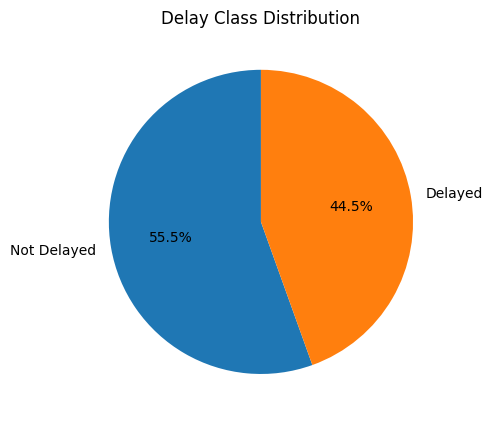

In [67]:
plt.figure(figsize = (5, 5))
df['Delay'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=['Not Delayed', 'Delayed'])
plt.title('Delay Class Distribution')
plt.ylabel('')
plt.savefig("../outputs/eda/delay_class_distribution.png")
plt.tight_layout()

### A. Univariate Analysis

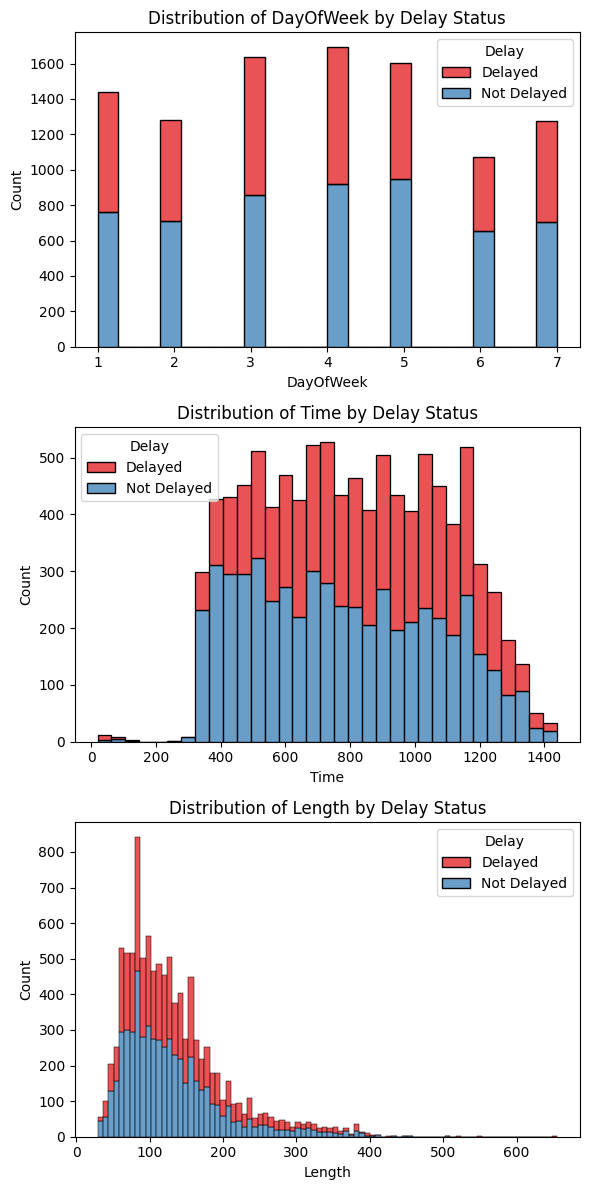

In [68]:
# Numerical Column
numerical_cols = ['DayOfWeek', 'Time', 'Length']

fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(6, 12)) 
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, hue='Delay', ax=axes[i], palette='Set1', multiple='stack')
    axes[i].set_title(f'Distribution of {col} by Delay Status')

plt.savefig("../outputs/eda/delay_vs_numerical_col.png")
plt.tight_layout()
plt.show()

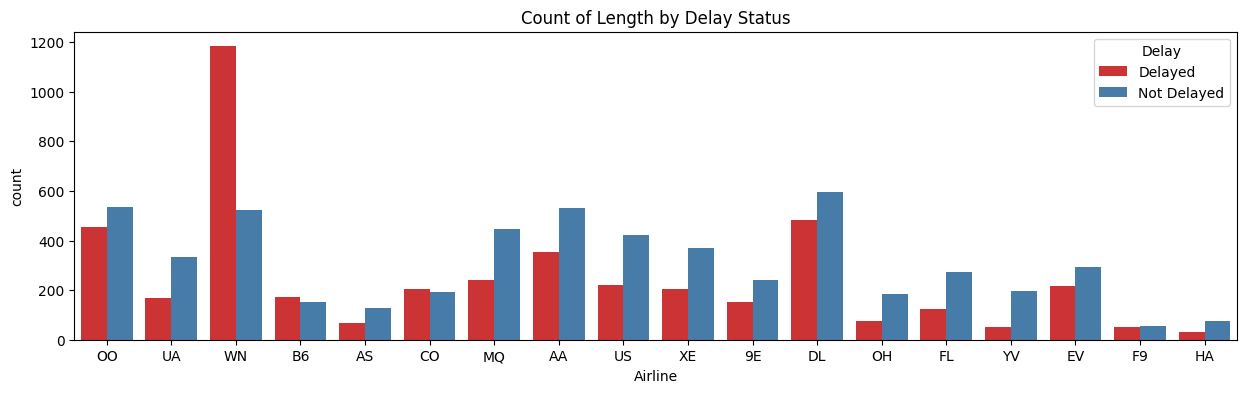

In [69]:
# Categorical Column
plt.figure(figsize=(15, 4))
sns.countplot(data=df, x='Airline', hue='Delay', palette='Set1')
plt.title(f'Count of {col} by Delay Status')
plt.savefig("../outputs/eda/delay_vs_length.png")
plt.show()

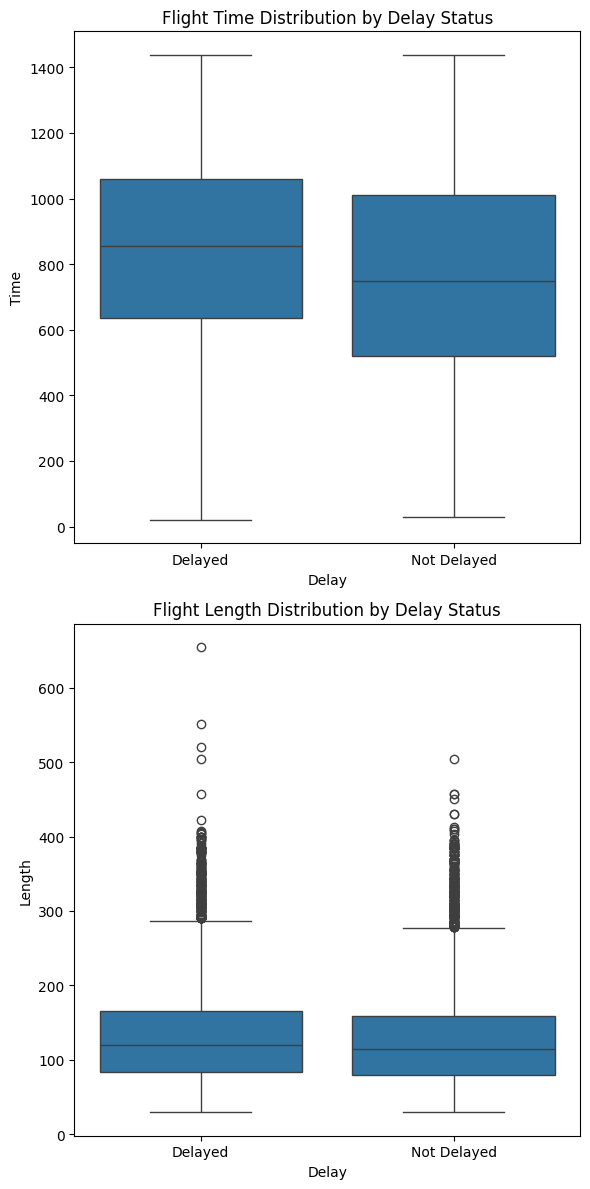

In [70]:
# Categorical Column
numerical_cols = ['Time', 'Length']

fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(6, 12)) 
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x='Delay', y=col, ax=axes[i])
    axes[i].set_title(f"Flight {col} Distribution by Delay Status")

plt.savefig("../outputs/eda/delay_vs_categorical_col.png")
plt.tight_layout()
plt.show()

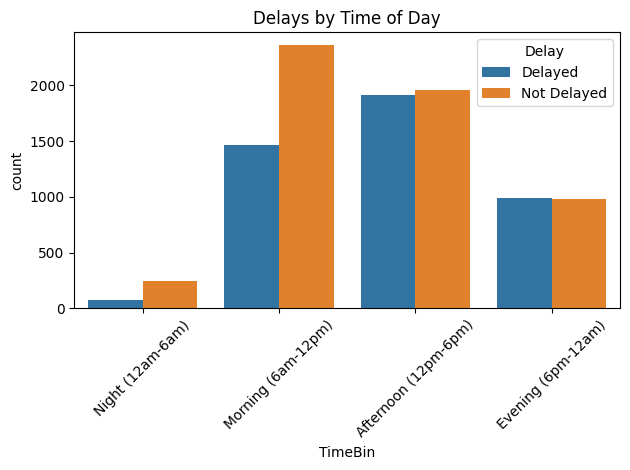

In [71]:
# Create time bins
timed_df = df.copy()
timed_df['TimeBin'] = pd.cut(df['Time'],
                       bins=[0, 360, 720, 1080, 1440],
                       labels=['Night (12am-6am)', 'Morning (6am-12pm)', 'Afternoon (12pm-6pm)', 'Evening (6pm-12am)'])

plt.figure()
sns.countplot(data=timed_df, x='TimeBin', hue='Delay')
plt.title('Delays by Time of Day')
plt.xticks(rotation=45)
plt.savefig("../outputs/eda/delay_vs_time.png")
plt.tight_layout()

### B. Correlation Heatmap

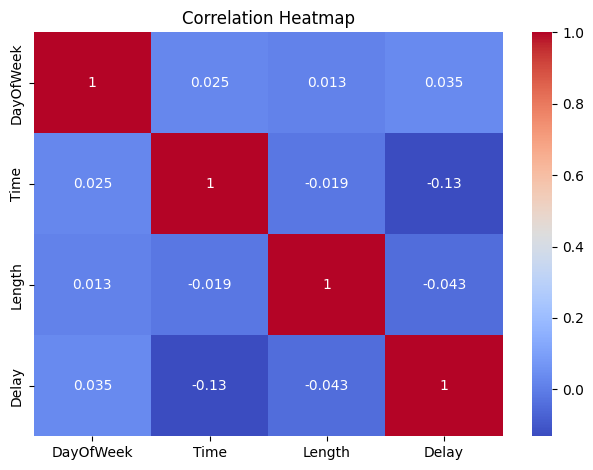

In [72]:
# Only numerical columns
num_df = df[['DayOfWeek', 'Time', 'Length']].copy()

# Add Delay as numeric for correlation
df['Delay'] = df['Delay'].astype('category')
num_df['Delay'] = df['Delay'].cat.codes

# Correlation
plt.figure()
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig("../outputs/eda/correlation_heatmap.png")
plt.tight_layout()

## 4. Feature Extraction

In [73]:
# df['Delay'] = df['Delay'].cat.codes
from sklearn.preprocessing import LabelEncoder

for col in ['Airline', 'AirportFrom', 'AirportTo']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

## 5. Train-Test split

In [18]:
from sklearn.model_selection import train_test_split

X = df.drop('Delay', axis=1)
y = df['Delay'].map({'Not Delayed':0, 'Delayed':1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (8000, 8)
Test shape: (2000, 8)


## 6.Model Building

In [74]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 7.Model Evaluation

In [75]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = rf_model.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy Score: 0.6475

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.76      0.70      1110
           1       0.63      0.51      0.56       890

    accuracy                           0.65      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.64      0.65      0.64      2000


Confusion Matrix:
 [[841 269]
 [436 454]]


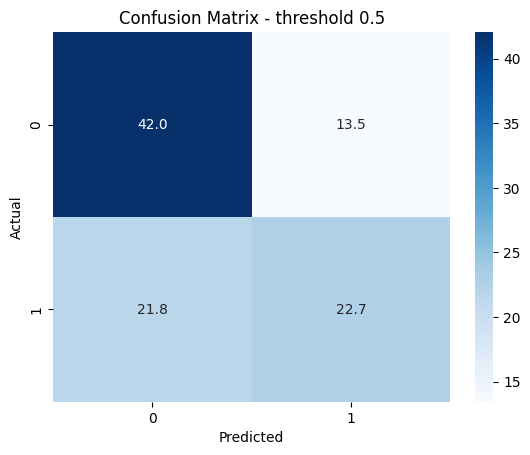

In [76]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum() * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - threshold 0.5')
plt.show()

## 8. Hyperparameter Tuning

In [77]:
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(random_state=42)
param_grids = {'n_estimators': [100, 200],
              'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2],
              'max_features': ['sqrt', 'log2'],
              'bootstrap': [True, False],
              'class_weight': [None, 'balanced']}

grid_search = GridSearchCV(estimator=rfc, 
                          param_grid=param_grids, 
                          cv = 5, 
                          scoring='accuracy', 
                          n_jobs=9, 
                          verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=9,
             param_grid={'bootstrap': [True, False],
                         'class_weight': [None, 'balanced'],
                         'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [78]:
print("Best params :: \n", grid_search.best_params_, end ='\n\n')
print("Best Score  :: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
best_model

Best params :: 
 {'bootstrap': True, 'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Best Score  ::  0.65425


RandomForestClassifier(max_depth=20, min_samples_leaf=2, random_state=42)

## 9. Best Model

In [79]:
selected_model = rf_model

### A. Default Threshold - 0.5

In [80]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = selected_model.predict(X_test)
y_prob = selected_model.predict_proba(X_test)[:, 1]

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy Score: 0.6475

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.76      0.70      1110
           1       0.63      0.51      0.56       890

    accuracy                           0.65      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.64      0.65      0.64      2000


Confusion Matrix:
 [[841 269]
 [436 454]]


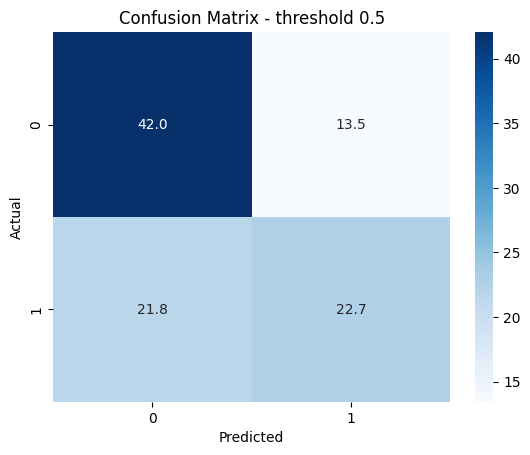

In [81]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum() * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - threshold 0.5')
plt.savefig("../outputs/results/default_threshold_cm.png")
plt.show()

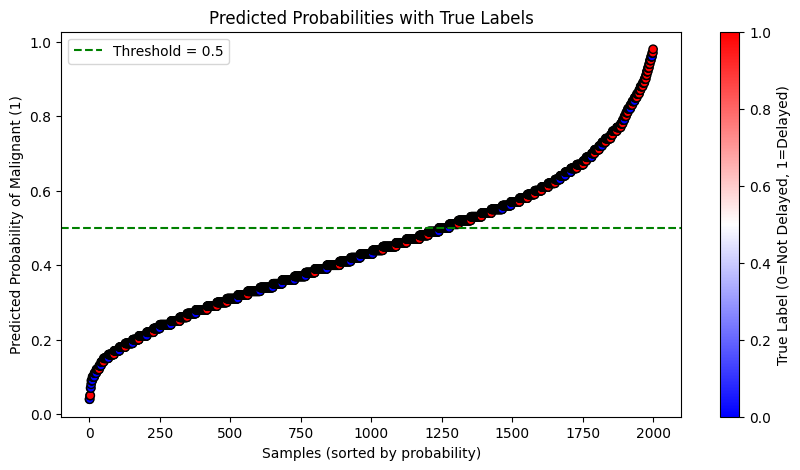

In [82]:
# Sort probabilities for better visualization
sorted_index = np.argsort(y_prob)
y_prob_sorted = y_prob[sorted_index]
y_test_sorted = y_test.values[sorted_index]  # if y_test is pandas Series

plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_prob_sorted)), y_prob_sorted, 
            c=y_test_sorted, cmap='bwr', edgecolor='k')
plt.axhline(0.5, color='green', linestyle='--', label='Threshold = 0.5')
plt.xlabel('Samples (sorted by probability)')
plt.ylabel('Predicted Probability of Malignant (1)')
plt.title('Predicted Probabilities with True Labels')
plt.legend()
plt.colorbar(label="True Label (0=Not Delayed, 1=Delayed)")
plt.savefig("../outputs/results/visual_representation.png")
plt.show()

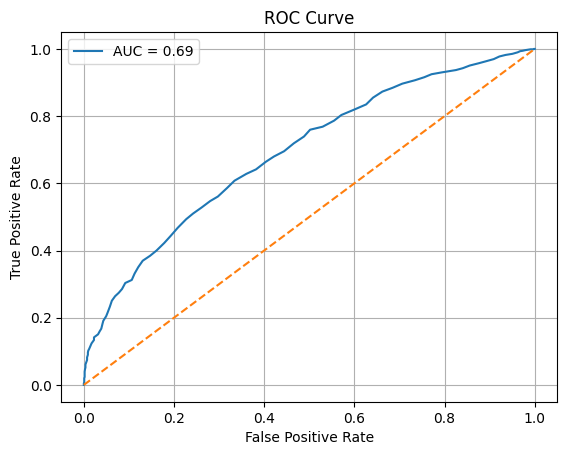

In [83]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.savefig("../outputs/results/roc_curve.png")
plt.show()

### B. Best Threshold

In [84]:
thresholds = np.arange(0, 1.01, 0.01)

best_threshold = 0.5
best_accuracy = 0

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    acc = accuracy_score(y_test, y_pred_t)
    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = t

y_pred_t = (y_prob >= best_threshold).astype(int)

print("Best Threshold:", best_threshold)
print("Best Accuracy:", best_accuracy)

Best Threshold: 0.52
Best Accuracy: 0.6485


In [85]:
print(f"Accuracy :: {accuracy_score(y_test, y_pred_t)}")
print(f"\nClassification report :: \n", classification_report(y_test, y_pred_t))

Accuracy :: 0.6485

Classification report :: 
               precision    recall  f1-score   support

           0       0.66      0.77      0.71      1110
           1       0.64      0.49      0.56       890

    accuracy                           0.65      2000
   macro avg       0.65      0.63      0.63      2000
weighted avg       0.65      0.65      0.64      2000



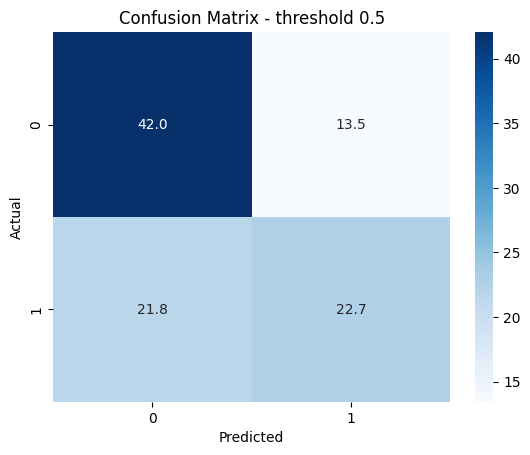

In [86]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum() * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - threshold 0.5')
plt.savefig("../outputs/results/best_threshold_cm.png")
plt.show()

## 10. Save and Load Model

In [87]:
import joblib

joblib.dump(selected_model, "../outputs/models/randomForest.pkl")
print("Model saved successfully!")

loaded_model = joblib.load("../outputs/models/randomForest.pkl")
y_pred_loaded = loaded_model.predict(X_test)

Model saved successfully!
